In [1]:
import os
import shutil
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# --- Dossiers source ---
# Pour Jupyter Notebook: utiliser le répertoire courant
BASE_PATH = '..\Datasets\Dataset'
# Chercher le répertoire qui contient "processed_dataset" ou "Dataset"
while BASE_PATH and not (os.path.exists(os.path.join(BASE_PATH, "processed_dataset_cropped")) or 
                         os.path.exists(os.path.join(BASE_PATH, "Dataset_cropped"))):
    parent = os.path.dirname(BASE_PATH)
    if parent == BASE_PATH:  # On est à la racine
        BASE_PATH = os.getcwd()  # Revenir au répertoire courant
        break
    BASE_PATH = parent

base_dir = os.path.join(BASE_PATH, "Dataset_without_background")
# Nouveau dossier de sortie pour les 4 classes
output_dir = os.path.join(BASE_PATH, "Processed_Dataset_without_background")

print(f"BASE_PATH: {BASE_PATH}")
print(f"base_dir existe: {os.path.exists(base_dir)}")
print(f"output_dir sera créé: {output_dir}")

# Définir les 4 classes
class_dirs = {
    "Normal": os.path.join(base_dir, "Normal Person ECG Images"),
    "Myocardial_Infarction": os.path.join(base_dir, "ECG Images of Myocardial Infarction Patients"),
    "Abnormal_Heartbeat": os.path.join(base_dir, "ECG Images of Patient that have abnormal heartbeat"),
    "History_MI": os.path.join(base_dir, "ECG Images of Patient that have History of MI")
}

# Vérifier que tous les dossiers existent
for class_name, class_path in class_dirs.items():
    exists = os.path.exists(class_path)
    print(f"  {class_name}: {exists} ({class_path})")


BASE_PATH: ..\Datasets
base_dir existe: True
output_dir sera créé: ..\Datasets\Processed_Dataset_without_background
  Normal: True (..\Datasets\Dataset_without_background\Normal Person ECG Images)
  Myocardial_Infarction: True (..\Datasets\Dataset_without_background\ECG Images of Myocardial Infarction Patients)
  Abnormal_Heartbeat: True (..\Datasets\Dataset_without_background\ECG Images of Patient that have abnormal heartbeat)
  History_MI: True (..\Datasets\Dataset_without_background\ECG Images of Patient that have History of MI)


In [3]:
# --- Créer les dossiers de sortie pour les 4 classes ---
class_output_dirs = {}
for class_name in class_dirs.keys():
    output_path = os.path.join(output_dir, class_name)
    os.makedirs(output_path, exist_ok=True)
    class_output_dirs[class_name] = output_path
    print(f"Créé: {output_path}")


Créé: ..\Datasets\Processed_Dataset_without_background\Normal
Créé: ..\Datasets\Processed_Dataset_without_background\Myocardial_Infarction
Créé: ..\Datasets\Processed_Dataset_without_background\Abnormal_Heartbeat
Créé: ..\Datasets\Processed_Dataset_without_background\History_MI


In [4]:
def clear_directory(path):
    """Vide un répertoire de tous ses fichiers et sous-dossiers"""
    if not os.path.exists(path):
        return
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isfile(full_path) or os.path.islink(full_path):
            os.remove(full_path)
        elif os.path.isdir(full_path):
            shutil.rmtree(full_path)

# Nettoyer les dossiers de sortie
for output_path in class_output_dirs.values():
    clear_directory(output_path)
    print(f"Nettoyé: {output_path}")


Nettoyé: ..\Datasets\Processed_Dataset_without_background\Normal
Nettoyé: ..\Datasets\Processed_Dataset_without_background\Myocardial_Infarction
Nettoyé: ..\Datasets\Processed_Dataset_without_background\Abnormal_Heartbeat
Nettoyé: ..\Datasets\Processed_Dataset_without_background\History_MI


In [5]:
# --- Paramètres de preprocessing ---
target_size = (224, 224)
blur_kernel_size = (5, 5)

# Optionnel: limiter le nombre d'images par classe
# Mettre None pour traiter toutes les images
max_images_per_class = None  # Changez en un nombre si vous voulez limiter


In [6]:
def auto_crop_content(img_gray_uint8: np.ndarray, pad: int = 8) -> np.ndarray:
    """
    Crop automatique du contenu de l'image en utilisant les contours.
    
    Parameters:
    -----------
    img_gray_uint8 : np.ndarray
        Image en niveaux de gris (uint8)
    pad : int
        Padding à ajouter autour du contenu détecté
    
    Returns:
    --------
    np.ndarray
        Image croppée
    """
    _, th = cv2.threshold(img_gray_uint8, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    cnts = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if len(cnts) == 0:
        return img_gray_uint8
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    H, W = img_gray_uint8.shape[:2]
    x0 = max(0, x - pad)
    y0 = max(0, y - pad)
    x1 = min(W, x + w + pad)
    y1 = min(H, y + h + pad)
    return img_gray_uint8[y0:y1, x0:x1]


In [7]:
def process_and_save_images(input_paths, output_dir, limit=None):
    """
    Traite et sauvegarde les images avec le preprocessing complet.
    
    Parameters:
    -----------
    input_paths : list
        Liste des chemins vers les images à traiter
    output_dir : str
        Dossier de destination
    limit : int, optional
        Nombre maximum d'images à traiter (None = toutes)
    """
    random.shuffle(input_paths)
    if limit:
        input_paths = input_paths[:limit]
    
    success_count = 0
    error_count = 0
    
    for idx, path in enumerate(input_paths, 1):
        try:
            # Charger l'image
            img = cv2.imread(path)
            if img is None:
                error_count += 1
                continue
            
            # Conversion en niveaux de gris
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Flou gaussien pour réduire le bruit
            blurred = cv2.GaussianBlur(gray, blur_kernel_size, 0)
            
            # Égalisation d'histogramme pour améliorer le contraste
            equalized = cv2.equalizeHist(blurred)
            
            
            # Redimensionnement à la taille cible
            resized = cv2.resize(equalized, target_size, interpolation=cv2.INTER_AREA)
            
            # Sauvegarder l'image traitée
            filename = os.path.basename(path)
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, resized)
            success_count += 1
            
            if idx % 50 == 0:
                print(f"  Traité {idx}/{len(input_paths)} images...")
                
        except Exception as e:
            error_count += 1
            print(f"  Erreur sur {os.path.basename(path)}: {e}")
    
    return success_count, error_count


In [8]:
# --- Traiter toutes les classes ---
print("=" * 70)
print("TRAITEMENT DES IMAGES PAR CLASSE")
print("=" * 70)

results = {}

for class_name, input_dir in class_dirs.items():
    if not os.path.exists(input_dir):
        print(f"\n⚠️  Dossier introuvable pour {class_name}: {input_dir}")
        continue
    
    print(f"\n>>> Traitement de la classe: {class_name}")
    print(f"    Source: {input_dir}")
    print(f"    Destination: {class_output_dirs[class_name]}")
    
    # Lister toutes les images
    image_files = [
        os.path.join(input_dir, f) for f in os.listdir(input_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    
    print(f"    Images trouvées: {len(image_files)}")
    
    # Traiter les images
    success, errors = process_and_save_images(
        image_files, 
        class_output_dirs[class_name], 
        limit=max_images_per_class
    )
    
    results[class_name] = {
        'total': len(image_files),
        'processed': success,
        'errors': errors
    }
    
    print(f"    ✅ Traitées avec succès: {success}")
    if errors > 0:
        print(f"    ❌ Erreurs: {errors}")

print("\n" + "=" * 70)
print("RÉSUMÉ FINAL")
print("=" * 70)
for class_name, stats in results.items():
    print(f"{class_name:25s}: {stats['processed']:4d} images traitées (sur {stats['total']:4d} disponibles)")
print("=" * 70)


TRAITEMENT DES IMAGES PAR CLASSE

>>> Traitement de la classe: Normal
    Source: ..\Datasets\Dataset_without_background\Normal Person ECG Images
    Destination: ..\Datasets\Processed_Dataset_without_background\Normal
    Images trouvées: 284
  Traité 50/284 images...
  Traité 100/284 images...
  Traité 150/284 images...
  Traité 200/284 images...
  Traité 250/284 images...
    ✅ Traitées avec succès: 284

>>> Traitement de la classe: Myocardial_Infarction
    Source: ..\Datasets\Dataset_without_background\ECG Images of Myocardial Infarction Patients
    Destination: ..\Datasets\Processed_Dataset_without_background\Myocardial_Infarction
    Images trouvées: 239
  Traité 50/239 images...
  Traité 100/239 images...
  Traité 150/239 images...
  Traité 200/239 images...
    ✅ Traitées avec succès: 239

>>> Traitement de la classe: Abnormal_Heartbeat
    Source: ..\Datasets\Dataset_without_background\ECG Images of Patient that have abnormal heartbeat
    Destination: ..\Datasets\Processed_

In [9]:
# --- Vérification finale ---
print("\n" + "=" * 70)
print("VÉRIFICATION DES RÉSULTATS")
print("=" * 70)

for class_name, output_path in class_output_dirs.items():
    if os.path.exists(output_path):
        num_images = len([f for f in os.listdir(output_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"{class_name:25s}: {num_images:4d} images dans {output_path}")
    else:
        print(f"{class_name:25s}: ❌ Dossier introuvable")

print("\n✅ Preprocessing terminé avec succès !")
print(f"📁 Images sauvegardées dans: {output_dir}")



VÉRIFICATION DES RÉSULTATS
Normal                   :  284 images dans ..\Datasets\Processed_Dataset_without_background\Normal
Myocardial_Infarction    :  239 images dans ..\Datasets\Processed_Dataset_without_background\Myocardial_Infarction
Abnormal_Heartbeat       :  233 images dans ..\Datasets\Processed_Dataset_without_background\Abnormal_Heartbeat
History_MI               :  172 images dans ..\Datasets\Processed_Dataset_without_background\History_MI

✅ Preprocessing terminé avec succès !
📁 Images sauvegardées dans: ..\Datasets\Processed_Dataset_without_background


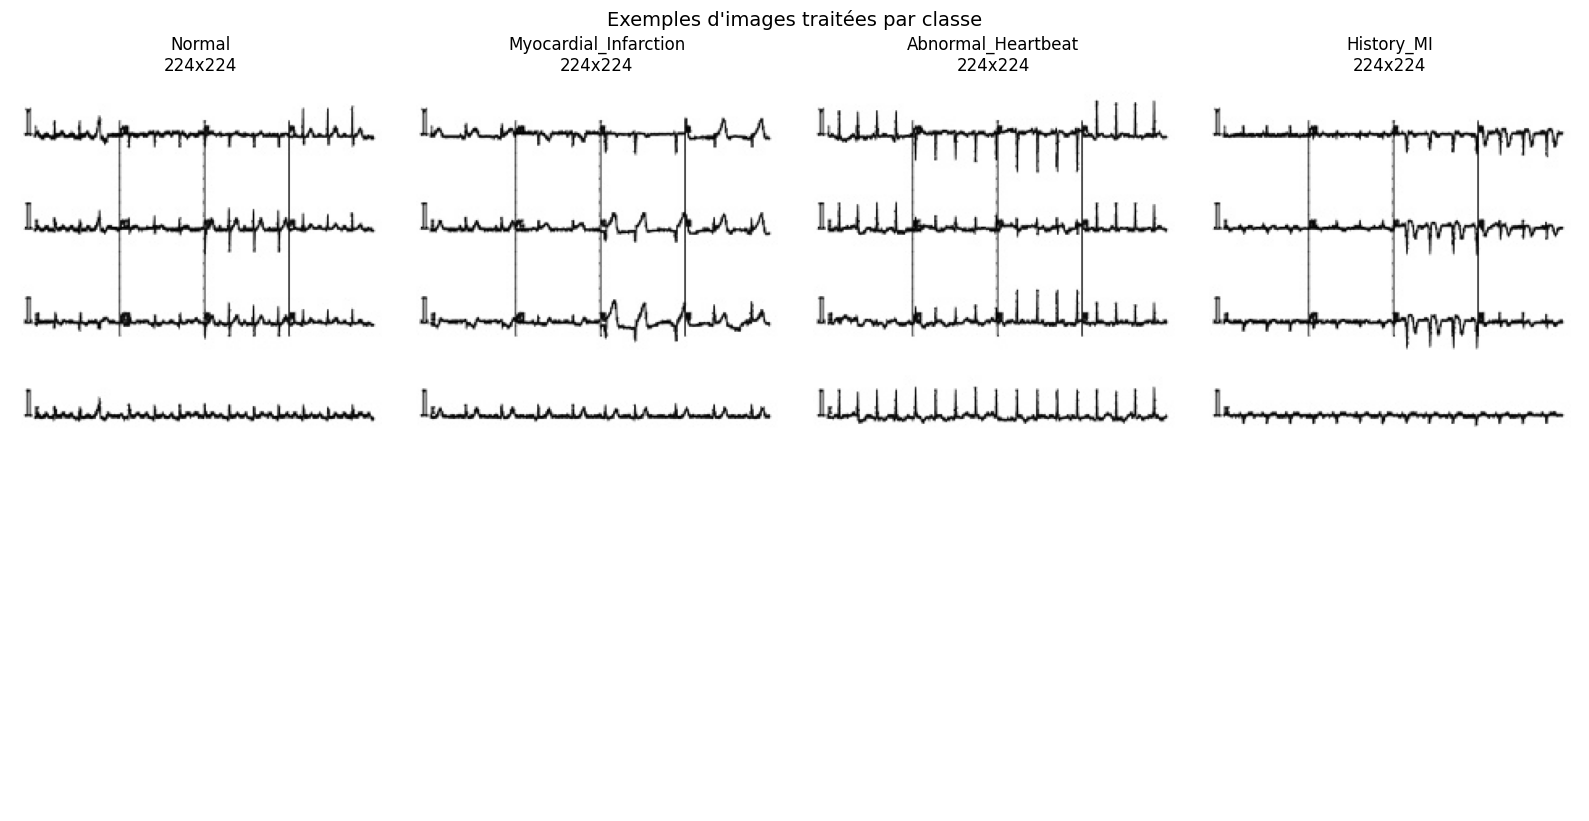

In [10]:
# --- Visualisation d'exemples par classe ---
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (class_name, output_path) in enumerate(class_output_dirs.items()):
    if not os.path.exists(output_path):
        continue
    
    # Prendre une image au hasard de cette classe
    image_files = [f for f in os.listdir(output_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        sample_file = random.choice(image_files)
        sample_path = os.path.join(output_path, sample_file)
        img = cv2.imread(sample_path)
        
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img_rgb, cmap='gray' if len(img_rgb.shape) == 2 else None)
            axes[idx].set_title(f'{class_name}\n{img.shape[1]}x{img.shape[0]}')
            axes[idx].axis('off')

# Masquer les axes non utilisés
for idx in range(len(class_output_dirs), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Exemples d\'images traitées par classe', y=1.02, fontsize=14)
plt.show()
